# Exploratory Data Analysis (EDA)

In [93]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats
from lightfm import LightFM
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm
from  sklearn.model_selection import train_test_split
%matplotlib inline

In [71]:
# Read csv files
data = pd.read_csv('retail.csv')

In [72]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


###  Missing values

In [74]:
def count_na(data):
    na_count = pd.DataFrame(data.isnull().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
    return na_count

count_na(data)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [75]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, format="%m/%d/%Y %H:%M")
data["CustomerID"] = data["CustomerID"].fillna(-9999)
data["CustomerID"] = data["CustomerID"].apply(lambda x: str(x)[:-2])
data["Description"] = data["Description"].fillna("Unkown")

In [76]:
count_na(data)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [77]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Negative Pricing 

In [78]:
neg_price = data[data["UnitPrice"]<0]
neg_price

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,-9999,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,-9999,United Kingdom


### Outlier detection

In [79]:
print(data.shape)

data = data[ np.abs((data['UnitPrice']-data['UnitPrice'].mean())/data['UnitPrice'].std()) <= 3]
data = data[ np.abs((data['Quantity']-data['Quantity'].mean())/data['Quantity'].std()) <= 3]

data = data[data["UnitPrice"] >= 0 ]
data = data[data["InvoiceNo"].astype(str).str[0] != "C"]
data = data[data["InvoiceNo"].astype(str).str[0] != "A"]
data = data[data["Quantity"] > 0 ]

print(data.shape)

(541909, 8)
(530795, 8)


In [80]:
data.describe()

,Quantity,UnitPrice
count,530795.000000,530795.000000
mean,9.765493,3.472191
std,25.387942,6.961868
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,660.000000,293.000000


In [81]:
data['Revenue'] = data['Quantity']*data['UnitPrice']

data['Date'] = data['InvoiceDate'].dt.date
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Week'] = data['InvoiceDate'].dt.week
data['Minute'] = data['InvoiceDate'].dt.minute

In [82]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26


### Revenue patterns

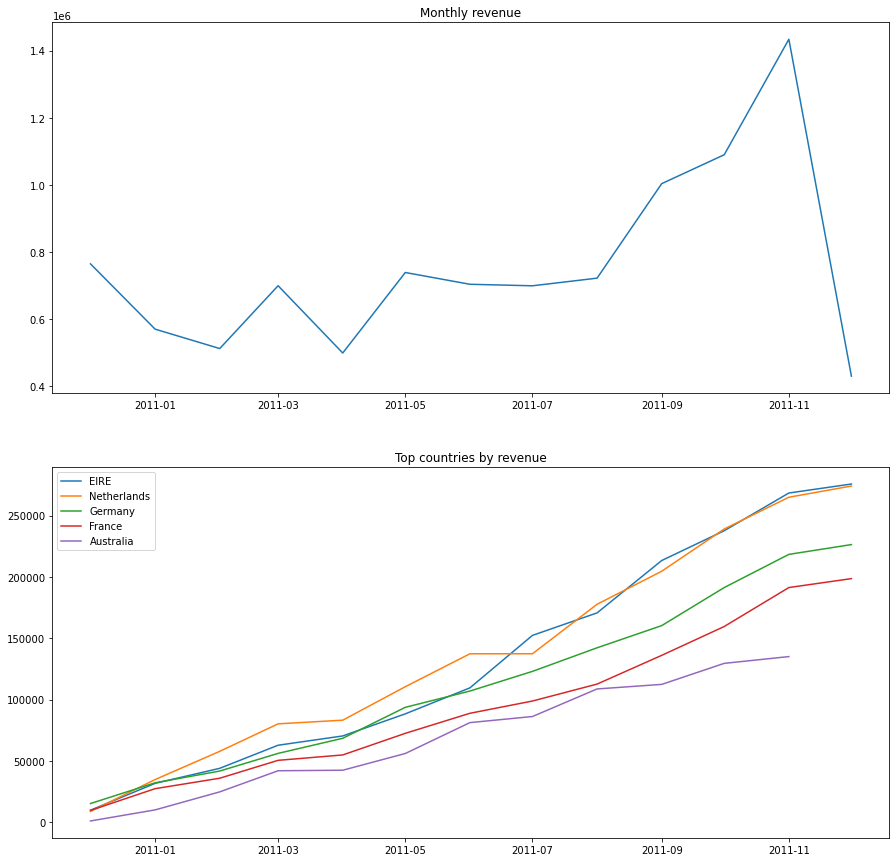

In [83]:
fig, ax = plt.subplots(2,1, figsize=(15, 15))

sales = data[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
sales['Day'] = 1
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
sales = sales.set_index('Date')
sales = sales.drop(['Year', 'Month', 'Day'], axis=1)

ax[0].plot(sales)
ax[0].set_title('Monthly revenue')        


sales_top = data[['Revenue', 'Country']].groupby(['Country']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Country'][1:6]

for c in sales_top:
    sales = data[data['Country'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)    
    ax[1].legend()
    ax[1].set_title('Top countries by revenue')            
    
plt.show()

### Purchase patterns

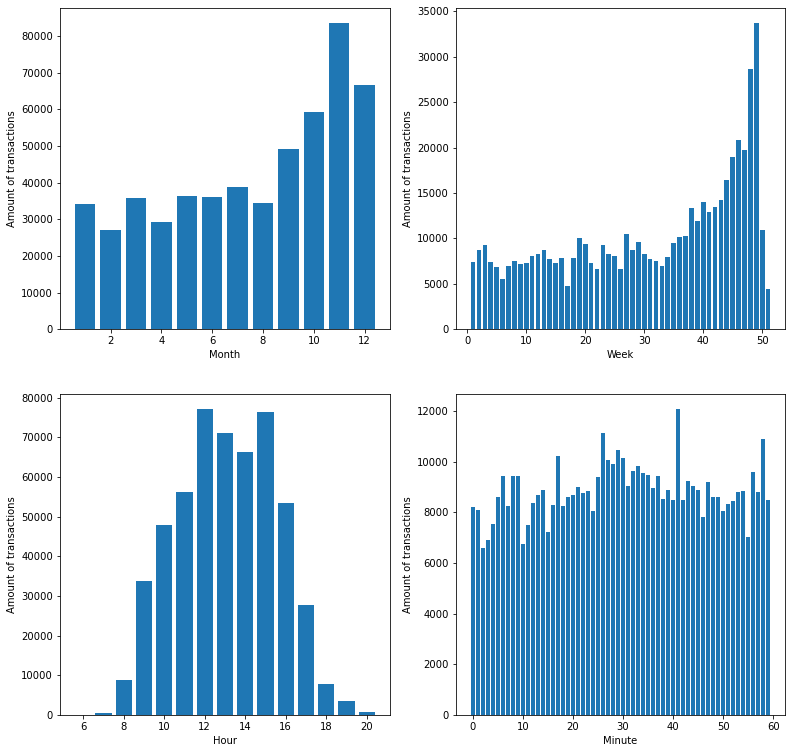

In [84]:
grps = np.array([['Month', 'Week'], ['Hour', 'Minute']])

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(13, 13))

for i in range(0, grps.shape[0]):
    for j in range(0, grps.shape[1]):
        grp_data = data[[grps[i,j], 'InvoiceNo']].groupby([grps[i,j]]).count()
        ax[i,j].bar(x=grp_data.index, height='InvoiceNo', data=grp_data)
        ax[i,j].set_ylabel('Amount of transactions')
        ax[i,j].set_xlabel(grps[i,j])
        
plt.show()

### Top sellers for different countries

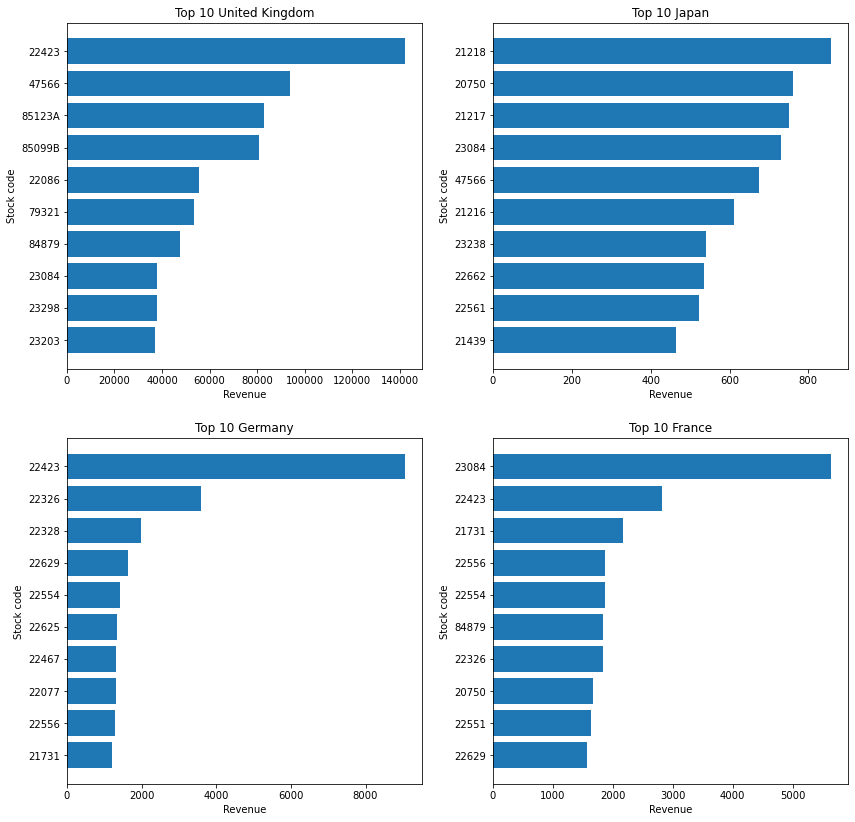

In [85]:
ctry = np.array([['United Kingdom', 'Japan'], ['Germany', 'France']])
fltr = ['DOT', 'POST', 'M']
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = data[data['Country'] == ctry[i,j]]
        grp_data = grp_data[~grp_data['StockCode'].isin(fltr)]
        grp_data = grp_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()
        
        ax[i,j].barh(y=grp_data.index, width='Revenue', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['StockCode'].tolist())
        ax[i,j].set_ylabel('Stock code')        
        ax[i,j].set_xlabel('Revenue')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()

### Global top sellers

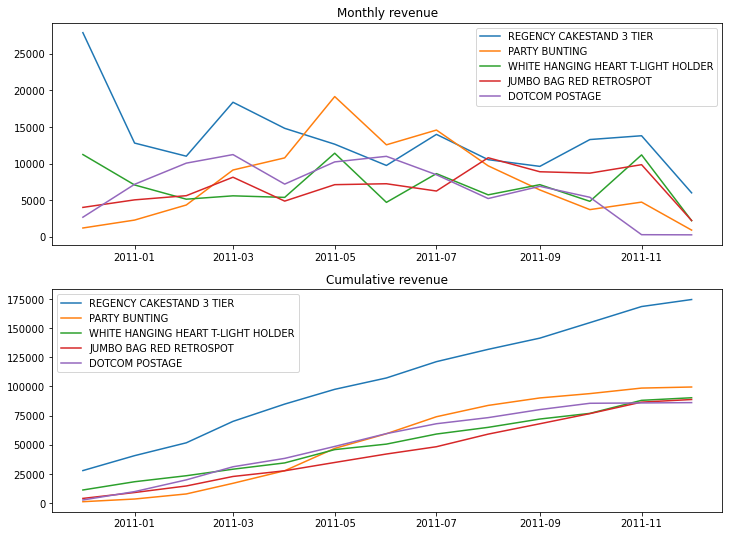

In [86]:
stock_top = data[['Revenue', 'Description']].groupby(['Description']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Description'][0:5]

fig, ax = plt.subplots(2,1, figsize=(12, 9))

for c in stock_top:
    sales = data[data['Description'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[0].plot(sales.Revenue, label=c)
    ax[0].legend()
    ax[0].set_title('Monthly revenue')            

for c in stock_top:
    sales = data[data['Description'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)
    ax[1].legend()
    ax[1].set_title('Cumulative revenue')

<Figure size 432x288 with 0 Axes>

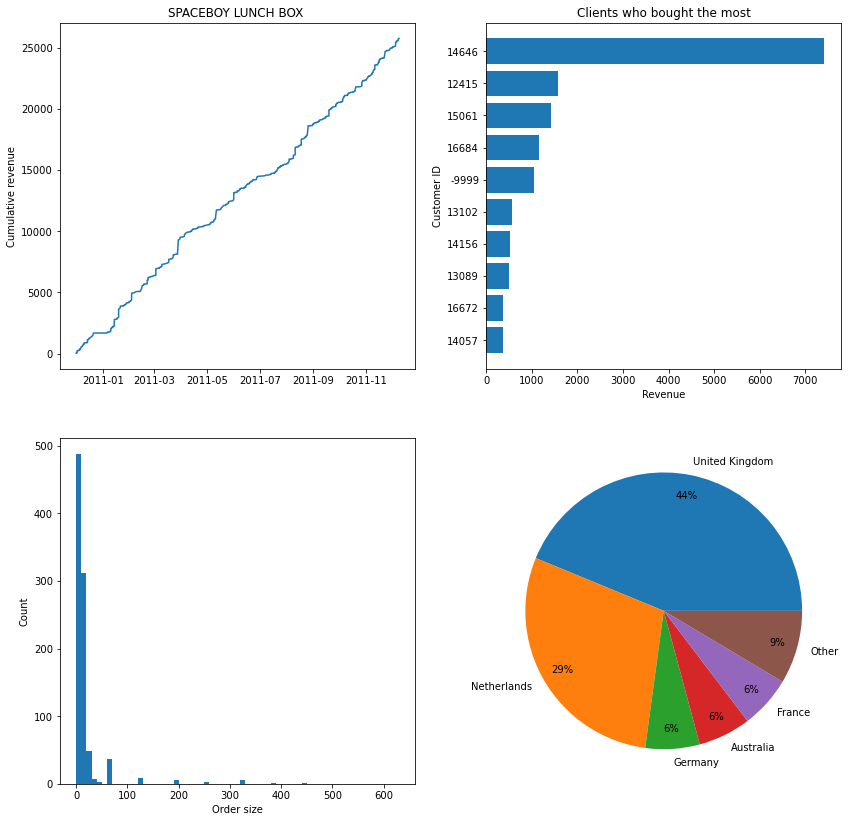

In [87]:
def top_stock(stockcode, top_n):
    """ Plot cumulative sales, 
    clients who bought the most, distribution of order size
    and pie chart with country % of buyers.    
    Parameters:
    stockcode: string with stock id
    top_n: how many bars etc to plot"""

    stock = data[data['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    ctry = stock[['Country', 'Revenue']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False)
    ctry = ((ctry/ctry.sum())*100).round(2)
    ctry = ctry[0:int(top_n/2)]
    ctry = ctry.append(pd.DataFrame(data=[100-ctry.sum()], columns=['Revenue'], index=['Other'] ))

    plt.clf()

    fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))
    
    ax[0,0].plot(stock['InvoiceDate'].dt.date, stock['ValueCum'])
    ax[0,0].set_ylabel('Cumulative revenue')        
    ax[0,0].set_title(stock['Description'].iloc[0])    

    ax[0,1].invert_yaxis()
    ax[0,1].barh(y=top_buyers.index, width='Revenue', data=top_buyers)
    ax[0,1].set_yticks(range(0,top_n))
    ax[0,1].set_yticklabels(top_buyers['CustomerID'].tolist())
    ax[0,1].set_ylabel('Customer ID')        
    ax[0,1].set_xlabel('Revenue')      
    ax[0,1].set_title("Clients who bought the most")        

    ax[1,0].hist(stock['Quantity'], bins=range(0,stock['Quantity'].max(), top_n) )
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Order size')     

    ax[1,1].pie(ctry['Revenue'], labels=ctry.index,  autopct='%1.0f%%', pctdistance=0.85)

    plt.show()
    
top_stock(stockcode="22629", top_n = 10)

### Deeper customer understanding

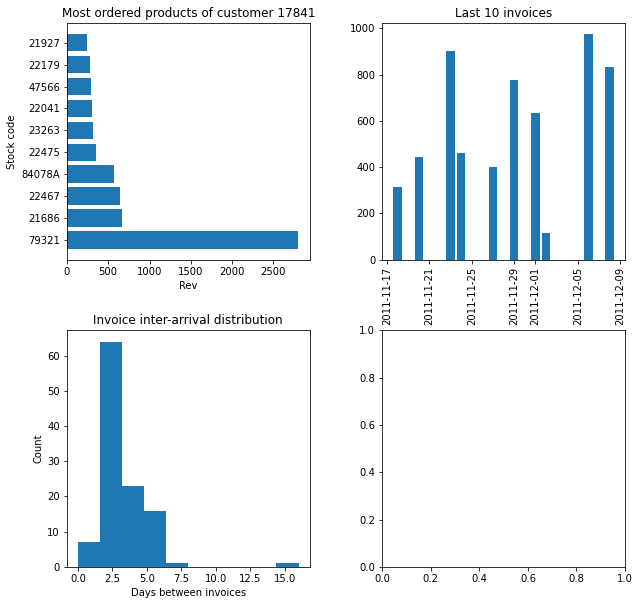

In [26]:
def deep_customer(customer_id):        
    c_data = data[data['CustomerID'] == customer_id ]

    most_ordered = c_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)
    most_ordered = most_ordered[0:10]

    last_inv = c_data[['InvoiceNo', 'Revenue', 'Date']].groupby(['InvoiceNo', 'Date'], as_index='False').sum().sort_values(by='Revenue')
    last_inv = last_inv.reset_index()
    last_inv = last_inv.set_index('Date').sort_index(ascending=False)
    last_inv = last_inv[0:10]

    inv_diff = data[data['CustomerID'] == customer_id][['InvoiceNo', 'Revenue', 'Date']]
    inv_diff = inv_diff[['Revenue', 'Date']].groupby(['Date'], as_index=False).sum()
    inv_diff = inv_diff.sort_values(by='Date', ascending=False)
    inv_diff['DateDiff'] = (inv_diff['Date'] - inv_diff['Date'].shift(-1) ).dt.days
    inv_diff = inv_diff.fillna(0, axis=1)

    fig, ax = plt.subplots(2,2, figsize=(10, 10))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    ax[0,0].barh(y=most_ordered.index, width="Revenue", data=most_ordered)
    ax[0,0].set_ylabel('Stock code')        
    ax[0,0].set_xlabel('Rev')     
    ax[0,0].set_title('Most ordered products of customer ' + str(customer_id))    

    ax[0,1].bar(x=last_inv.index, height='Revenue', data=last_inv)
    ax[0,1].set_title('Last 10 invoices')    

    ax[1,0].hist(inv_diff['DateDiff'])
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Days between invoices')     
    ax[1,0].set_title('Invoice inter-arrival distribution')    

    plt.sca(ax[0,1])
    plt.xticks(rotation=90)

    plt.show()
    
deep_customer(customer_id = '17841')

### Customer consumption habits

In [27]:
def interarrival(cid):
    s = data[data['CustomerID'] == str(cid)].sort_values(by=['Date'])['Date']    
    x = (s - s.shift(1)).dropna()
    
    if x.empty:
        return 0
    
    else:
        return x.dt.days.mean()

In [28]:
c_data = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()
c_data.columns = ['CustomerID', 'i_first']

c_data['i_first'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()['InvoiceDate']
c_data['i_last'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].max()['InvoiceDate']

c_data['d_as_customer']  = (max(c_data['i_last']) - c_data['i_first']).dt.days
c_data['d_last_invoice']  = (max(c_data['i_last']) - c_data['i_last'] ).dt.days

c_data['i_last_30D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x < 30 else 0)
c_data['i_last_90D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 30 and x < 90 else 0)
c_data['i_last_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 90 and x < 180 else 0)
c_data['i_over_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 180 else 0)

c_data['i_arrival_rate'] = c_data['CustomerID'].apply(interarrival)

c_data['t_invoices'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].count()['InvoiceDate']
c_data['t_units'] = data[['CustomerID', 'Quantity']].groupby('CustomerID', as_index=False)['Quantity'].sum()['Quantity']
c_data['t_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].sum()['Revenue']

c_data['u_orders'] = data[['CustomerID', 'StockCode']].groupby('CustomerID', as_index=False).nunique()['StockCode']
c_data['pct_rev_total'] = (c_data['t_rev']/data['Revenue'].sum())*100
c_data['avg_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].mean()['Revenue']

c_data['a_rate_week'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x <  7  else 0)
c_data['a_rate_2week'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 7  and x < 14 else 0)
c_data['a_rate_month'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 14 and x < 30 else 0)
c_data['a_rate_small'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x >= 30 else 0)

c_data = c_data[c_data['CustomerID'] != str(-9999)]

In [29]:
c_data.round(2).head()

,CustomerID,i_first,i_last,d_as_customer,d_last_invoice,i_last_30D,i_last_90D,i_last_180D,i_over_180D,i_arrival_rate,t_invoices,t_units,t_rev,u_orders,pct_rev_total,avg_rev,a_rate_week,a_rate_2week,a_rate_month,a_rate_small
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,366,1,1,0,0,0,2.02,182,2458,4310.00,103,0.04,23.68,1,0,0,0
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,357,74,0,1,0,0,9.43,31,2341,1797.24,22,0.02,57.98,0,1,0,0
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,18,18,1,0,0,0,0.00,72,630,1457.55,72,0.01,20.24,1,0,0,0
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,309,309,0,0,0,1,0.00,17,197,334.40,17,0.00,19.67,1,0,0,0
5,12352,2011-02-16 12:33:00,2011-11-03 14:37:00,296,35,0,1,0,0,3.13,84,535,2129.54,59,0.02,25.35,1,0,0,0


#### Individual features

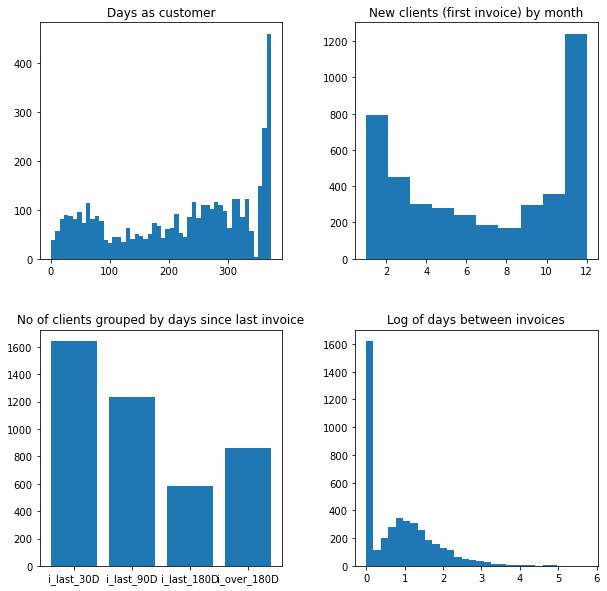

In [30]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax[0,0].hist(c_data['d_as_customer'], bins=50)
ax[0,0].set_title('Days as customer')        

ax[1,0].bar(x=['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D'], height=c_data[['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D']].sum())
ax[1,0].set_title('No of clients grouped by days since last invoice')        

ax[0,1].hist(c_data['i_first'].dt.month)
ax[0,1].set_title('New clients (first invoice) by month')        

ax[1,1].hist(c_data['i_arrival_rate'].apply(lambda x: np.log(x+1)), bins=30)
ax[1,1].set_title('Log of days between invoices')        


plt.show()

#### Correlation matrix of continuous features

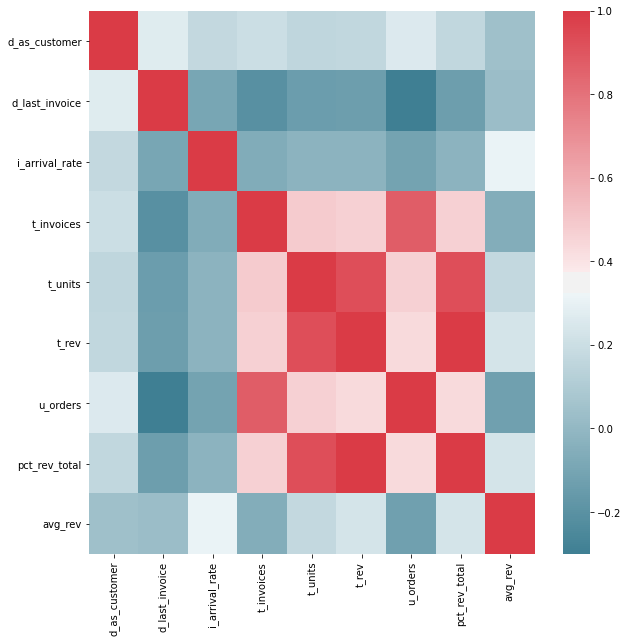

In [31]:
c_data_corr = c_data.drop(['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D', 
                           'a_rate_week', 'a_rate_2week', 'a_rate_month', 'a_rate_small'], axis=1).corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c_data_corr, cmap=cmap)
plt.show()

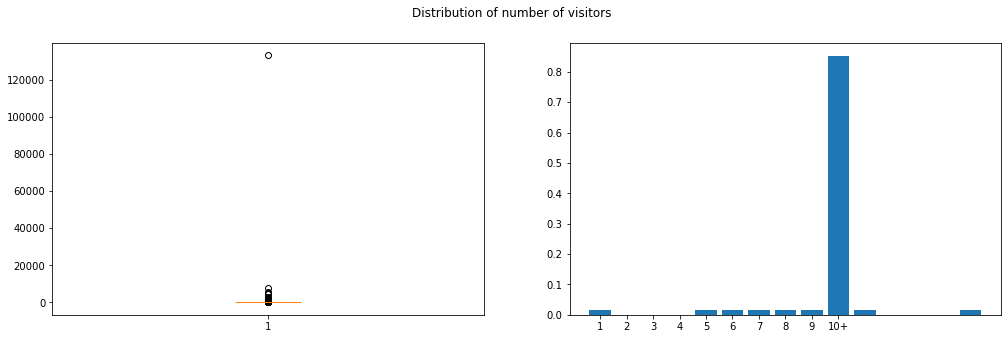

98.47% of visitors have more than 1 visit!


In [114]:
# Distribution of number of visitors

data1 = data['CustomerID'].value_counts() 
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per CustomerID

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of visitors")

plt.show()
print("{0:.2f}% of visitors have more than 1 visit!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

# Data preparation 

In [32]:
df = data.copy()

In [33]:
#remove irrelevant articles (explain in the report)

df= df.dropna(subset = ['CustomerID'])
df = df[df['UnitPrice'] > 0]
df = df[df['Quantity']>0]
df = df[~df['StockCode'].isin(['M','POST','DOT','C2'])]

## Reduce Sparsity

In [34]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [35]:
# get limited dataset
df_limited = threshold_ratings(df, 3, 3)

Raw dataset info 
-----------------
Number of users: 4325
Number of items: 3915
Sparsity: 3.116%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 4204
Number of items: 3636
Sparsity: 3.448%


In [36]:
df_limited

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-09,9,12,2011,12,49,50
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-09,9,12,2011,12,49,50
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-09,9,12,2011,12,49,50


# Train-test split

In [37]:
# Train-test split
start_train = df_limited['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(10, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['InvoiceDate'] > start_train) & (df_limited['InvoiceDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.71


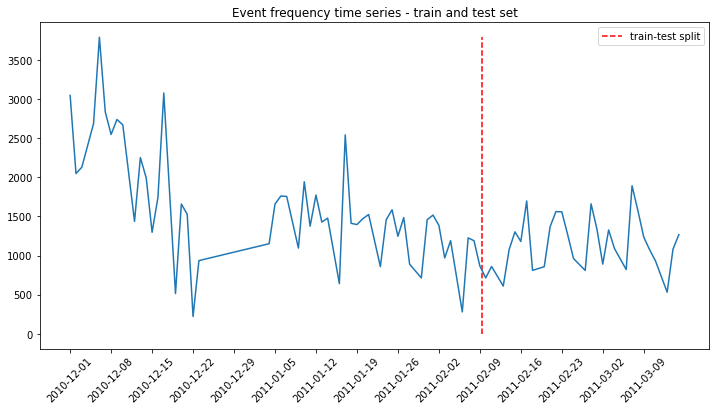

In [38]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

In [39]:

# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2988, 1845) and test set shape: (2988, 1845)
train set percentage of zeros: 99.13282760672318 and test set percentage of zeros: 99.52804896188185


In [40]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [41]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute,train_split
1776,536544,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-01 14:32:00,4.21,-9999,United Kingdom,4.21,2010-12-01,1,12,2010,14,48,32,1
2992,536592,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-01 17:06:00,4.21,-9999,United Kingdom,4.21,2010-12-01,1,12,2010,17,48,6,1
5449,536862,85099B,JUMBO BAG RED RETROSPOT,2,2010-12-03 11:13:00,4.21,-9999,United Kingdom,8.42,2010-12-03,3,12,2010,11,48,13,1
5544,536864,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-03 11:27:00,4.21,-9999,United Kingdom,4.21,2010-12-03,3,12,2010,11,48,27,1
5681,536865,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-03 11:28:00,4.21,-9999,United Kingdom,4.21,2010-12-03,3,12,2010,11,48,28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82366,543200,85099B,JUMBO BAG RED RETROSPOT,1,2011-02-04 13:03:00,4.13,-9999,United Kingdom,4.13,2011-02-04,4,2,2011,13,5,3,1
82412,543201,85099B,JUMBO BAG RED RETROSPOT,1,2011-02-04 13:03:00,4.13,-9999,United Kingdom,4.13,2011-02-04,4,2,2011,13,5,3,1
84952,543451,85099B,JUMBO BAG RED RETROSPOT,2,2011-02-08 12:13:00,4.13,-9999,United Kingdom,8.26,2011-02-08,8,2,2011,12,6,13,1
85099,543461,85099B,JUMBO BAG RED RETROSPOT,1,2011-02-08 13:35:00,4.13,-9999,United Kingdom,4.13,2011-02-08,8,2,2011,13,6,35,1


# FIT THE ALS MODEL

In [42]:
# initialize a model
alpha = 3
als_model = AlternatingLeastSquares(factors=25, regularization=0.1, iterations=1000, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights

# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

# ALS MODEL METHODS

In [43]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('22111', 1.102854),
 ('22834', 1.0743258),
 ('22867', 1.0533507),
 ('84029G', 1.0222887),
 ('22113', 1.0121078),
 ('82482', 1.0081154),
 ('85123A', 1.0071918),
 ('82486', 1.0058404),
 ('22837', 0.9950861),
 ('22112', 0.9893819)]

In [44]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22633', 1.0000001),
 ('22867', 0.89950013),
 ('22866', 0.88780934),
 ('22632', 0.8765389),
 ('22865', 0.87560517),
 ('82011C', 0.6840564),
 ('22834', 0.64337987),
 ('72799F', 0.6275673),
 ('21586', 0.6269442),
 ('22114', 0.6224761)]

In [45]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.8637100180860764
The top N (itemid, score) contributions for this user/item pair are:
 [('22633', 0.29275775525910563), ('22632', 0.21820699005927222), ('21730', 0.06292348055267842), ('84029E', 0.06117109834031419), ('84029G', 0.05586813151444945), ('71053', 0.03570582710482145), ('82483', 0.03404057664328547), ('22752', 0.03245252220729056), ('82494L', 0.029617052385279057), ('22411', 0.020276686660718413)]


# EVALUATION

In [46]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [47]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [48]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.117783,0.066594
map,0.054338,0.027960
ndcg,0.119659,0.065333
auc,0.523073,0.512717


# Cold start problem

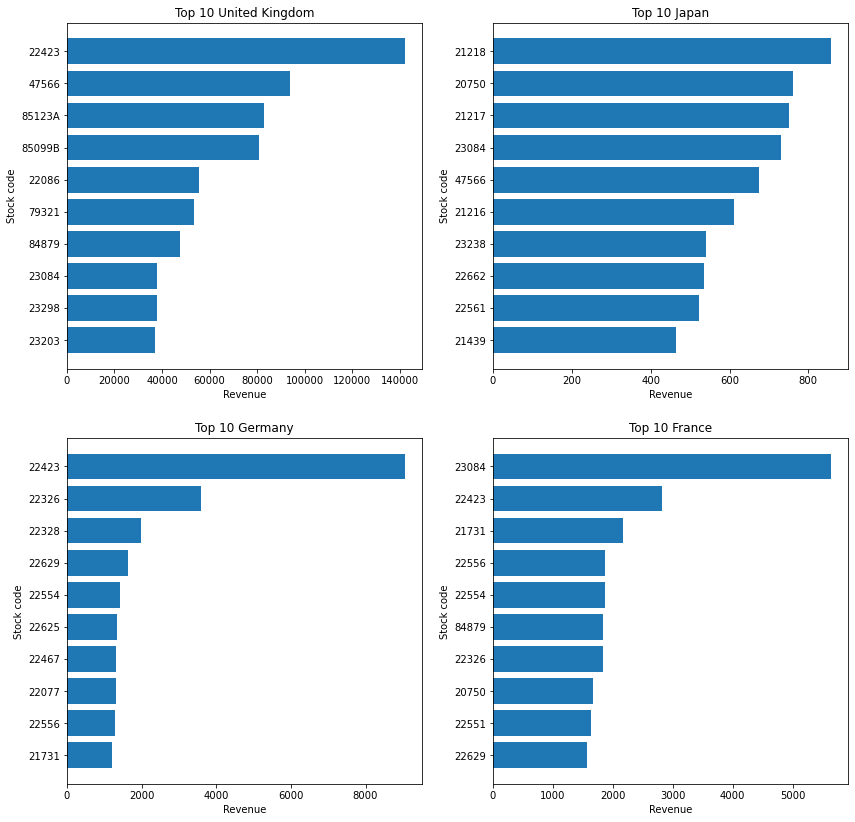

In [112]:
# use this 4 countries for example how we will do the recommendation system

ctry = np.array([['United Kingdom', 'Japan'], ['Germany', 'France']])
fltr = ['DOT', 'POST', 'M']
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = df[data['Country'] == ctry[i,j]]
        grp_data = grp_data[~grp_data['StockCode'].isin(fltr)]
        grp_data = grp_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()
        
        ax[i,j].barh(y=grp_data.index, width='Revenue', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['StockCode'].tolist())
        ax[i,j].set_ylabel('Stock code')        
        ax[i,j].set_xlabel('Revenue')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()

##  Trying to use ligthFM

In [99]:
interactions_selected = df[['CustomerID', 'StockCode','Quantity']]

In [100]:
user_book_interaction = pd.pivot_table(interactions_selected, index='CustomerID', columns='StockCode', values='Quantity')
# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
# convert to csr matrix
user_book_interaction_csr = csr_matrix(user_book_interaction.values)
user_book_interaction_csr

<4325x3915 sparse matrix of type '<class 'numpy.float64'>'
	with 269577 stored elements in Compressed Sparse Row format>

In [101]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model = model.fit(user_book_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [102]:
model.predict(user_map[user_id],item_map[item_id])

TypeError: unhashable type: 'list'